In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
from scipy.stats import norm
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, cross_validate, cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, balanced_accuracy_score, mean_squared_error as rmse
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold
from mlxtend.classifier import StackingCVClassifier, EnsembleVoteClassifier
from mlxtend.feature_selection import ColumnSelector
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer

In [16]:

params = {'n_estimators': [300, 400, 500, 600, 700],
              'learning_rate': [0.01, 0.02, 0.03, 0.05, 0.07],
              'gamma': [0.5, 1, 1.5, 2, 5],
              'max_depth': [3, 4, 5, 6],
              'subsample': [0.6, 0.8, 1.0],
              'colsample_bytree': [0.6, 0.8, 1.0],
              'min_child_weight': [1, 2, 3, 4, 5]}

seed = 42
st_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

def calc_scores(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    recall_0, recall_1 = recall_score(y_test, y_pred, pos_label=0), recall_score(y_test, y_pred, pos_label=1)
    precision_0, precision_1 =  precision_score(y_test, y_pred, pos_label=0), precision_score(y_test, y_pred, pos_label=1)
    acc = balanced_accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
    arr = np.array([[acc, precision_0, recall_0, precision_1, recall_1,auc_score]])
    return pd.DataFrame(data=arr, columns=["balanced_accuracy", "recall_0", "precision_0", "recall_1", "precision_1", "auc"])

def recall_0(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=0)

def precision_0(y_true, y_pred):
    return precision_score(y_true, y_pred, pos_label=0)

scoring = {"balanced_accuracy": make_scorer(balanced_accuracy_score),
           "recall_0": make_scorer(recall_0), "precision_0": make_scorer(precision_0),
           "recall_1": make_scorer(recall_score), "precision_1": make_scorer(precision_score), "auc": "roc_auc" }

#cross_validation

def print_score_comparison(raw_score, emb_score, target_feature="posOutcome",
                           header_1="Raw Score", header_2="Embedding Score"):
    print("\t\t{0}\n\t\t\t{1}\t\t{2}".format(target_feature, header_1, header_2))
    print("\t\t-----------------------------------------------")
    print("balanced_accuracy:\t{0:.3%}\t\t\t{1:.3%}\n".format(raw_score["balanced_accuracy"].mean(), emb_score["balanced_accuracy"].mean()))
    print("precision_0:\t\t{0:.3%}\t\t\t{1:.3%}\n".format(raw_score["precision_0"].mean(), emb_score["precision_0"].mean()))
    print("recall_0:\t\t{0:.3%}\t\t\t{1:.3%}\n".format(raw_score["recall_0"].mean(), emb_score["recall_0"].mean()))
    print("precision_1:\t\t{0:.3%}\t\t\t{1:.3%}\n".format(raw_score["precision_1"].mean(), emb_score["precision_1"].mean()))
    print("recall_1:\t\t{0:.3%}\t\t\t{1:.3%}\n".format(raw_score["recall_1"].mean(), emb_score["recall_1"].mean()))
    print("auc:\t\t\t{0:.3%}\t\t\t{1:.3%}\n".format(raw_score["auc"].mean(), emb_score["auc"].mean()))

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time

    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

def param_tuning(X, y, n_folds=5, param_comb=25, scoring='roc_auc', jobs=12):
    xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    rand_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring=scoring, n_jobs=jobs,
                                   cv=skf.split(X, y), verbose=3, random_state=42)

    start_time = timer(None) # timing starts from this point for "start_time" variable
    rand_search.fit(X, y)
    timer(start_time)
    print("Best Score: {:.3%}".format(rand_search.best_score_))
    print(rand_search.best_params_)
    return rand_search

score_cols = ["test_balanced_accuracy","test_precision_0", "test_recall_0",
               "test_precision_1","test_recall_1", "test_auc"]

def get_scores(cv_results, score_keys=None, df_cols=None):
    if score_keys is None:
        score_keys = score_cols
    if df_cols is None:
        score_keys = score_cols
    scores = np.empty([1, len(score_keys)])
    for i, s in enumerate(score_keys):
        scores[0][i] = np.mean(cv_results[s])
    scores_df = pd.DataFrame(data=scores, columns=df_cols)
    return scores_df

def evaluate_embedding(path, outcome_df, target="posOutcome", merge_col="patient_ID", n_jobs=-1):
    emb_df = pd.read_csv(path, sep="\t")
    emb_outcome_df = pd.merge(outcome_df, emb_df, on=merge_col)
    X_emb, y_emb = emb_outcome_df[emb_outcome_df.columns.difference([merge_col, target])], emb_outcome_df[target]
    X_train_emb, X_test_emb, y_train_emb, y_test_emb = train_test_split(X_emb, y_emb, test_size=0.3, random_state=seed)
    rand_search_emb = param_tuning(X_train_emb, y_train_emb, jobs=n_jobs)
    params = rand_search_emb.best_params_
    clf_emb = rand_search_emb.best_estimator_
    cv_res = cross_validate(clf_emb, X_train_emb, y_train_emb, scoring=scoring, n_jobs=n_jobs, verbose=1, return_train_score=True,
                            cv=st_cv)
    cv_res_df = get_scores(cv_res)
    clf_emb.fit(X_train_emb, y_train_emb)
    test_scores_df = calc_scores(clf_emb, X_test_emb, y_test_emb)

    return params, cv_res_df, test_scores_df

def load_features(path):
    feats = []
    with open(path, "r") as fp:
        for line in fp.readlines():
            feats.append(line.strip())

    return feats
def evaluate_ge(x_train, y_train, x_test, y_test, outcome_cols, feats=None, jobs=-1, scoring=scoring, rand_scoring="roc_auc", target="posOutcome"):
    if feats is not None:
        cols = outcome_cols + feats
        x_train = x_train[cols]
        x_test = x_test[cols]
    rand_search = param_tuning(x_train, y_train, scoring=rand_scoring, jobs=jobs)
    params = rand_search.best_params_
    clf = XGBClassifier(**params)
    cv_res = cross_validate(clf, x_train, y_train,scoring=scoring, cv=st_cv, n_jobs=jobs)

    cv_res_df = get_scores(cv_res, score_cols, df_cols=["balanced_accuracy", "recall_0", "precision_0", "recall_1", "precision_1", "auc"])
    clf.fit(x_train, y_train)
    test_scores_df = calc_scores(clf, x_test, y_test)

    return params, clf, cv_res_df, test_scores_df

def discretize_dataset(X, features, bins_labels = None):
    if bins_labels is None:
	    bins_labels = [-1, 0, 1]
    X_disc = X[features]
    bin_dict = {}

    for ft in features:
        r1 = X_disc[ft].mean() - X_disc[ft].std() / 2
        r2 = X_disc[ft].mean() + X_disc[ft].std() / 2
        bin_dict[ft]= [-np.inf, r1, r2, np.inf]
    le = LabelEncoder()

    le.fit(bins_labels)

    for ft in bin_dict:
        X_disc[ft] = le.transform(pd.cut(X_disc[ft], bins=bin_dict[ft], labels=bins_labels))

    ohe = OneHotEncoder(handle_unknown="ignore")
    transformed = ohe.fit_transform(X_disc).toarray()
    X_disc = pd.DataFrame(transformed, columns=ohe.get_feature_names(features))
    return X_disc

def optimize_k(df, target, exclude=None):
    if exclude is None:
        exclude = ["patient_ID"]
    df = df.drop(exclude, axis=1)
    data = df.to_numpy()
    errors = []
    for k in range(1, 20, 2):
        imputer = KNNImputer(n_neighbors=k)
        imputed = imputer.fit_transform(data)
        df_imputed = pd.DataFrame(imputed, columns=df.columns)

        X = df_imputed.drop(target, axis=1)
        y = df_imputed[target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model = RandomForestClassifier()
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        error = rmse(y_test, preds)
        errors.append({'K': k, 'RMSE': error})

    return errors

In [3]:
#Load the datasets

ge_df = pd.read_csv("datasets/merged-combat15.csv")
state_df = pd.read_csv("datasets/state_and_outcome.csv")

In [4]:
#Feature engineering

state_df = state_df.drop(["series_id", "channel_count", "RFS", "DFS",
                          "pCR", "posOutcome2"], axis=1)

In [5]:
gpl_vals = state_df["gpl"].unique()
print(gpl_vals)
pam_subtypes = state_df["pam_coincide"].unique()
print(pam_subtypes)
p5_types = state_df["p5"].unique()
print(p5_types)
tumor_types = state_df["tumor"].unique()
print(tumor_types)

['GPL570' 'GPL96' 'GPL1708,GPL4133' 'GPL5049' 'GPL1223' 'GPL5325']
['LumB' 'Her2' 'Basal' nan 'LumA' 'Normal']
['k5' 'k3' 'k1' 'k2' 'k4' nan]
['T3' 'T2' 'T4' 'T1' nan 'T0']


In [6]:
state_df = state_df.dropna(axis=0, subset=["pam_coincide", "p5"])
state_df = state_df.reset_index(drop=True)

In [7]:
state_df["tumor"] = state_df["tumor"].astype("category").cat.codes
state_df["pam_coincide"] = pam_code_df = state_df["pam_coincide"].astype("category").cat.codes
state_df["p5"] = p5_code_df = state_df["p5"].astype("category").cat.codes
state_df["gpl"] = gpl_code = state_df["gpl"].astype("category").cat.codes
state_df

,patient_ID,gpl,ER,HER2,PR,node,tumor,pam_coincide,p5,posOutcome
0,809184,4,1.0,0.0,0.0,1.0,3,3,4,0
1,809185,4,0.0,0.0,0.0,1.0,3,3,4,1
2,809186,4,0.0,0.0,0.0,1.0,3,1,2,0
3,809187,4,1.0,1.0,1.0,1.0,3,3,4,0
4,809188,4,1.0,0.0,1.0,1.0,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2220,491199,4,0.0,0.0,0.0,0.0,2,0,1,1
2221,491270,4,1.0,1.0,1.0,0.0,2,3,4,1
2222,491200,4,0.0,1.0,0.0,1.0,2,1,1,1
2223,491201,4,0.0,0.0,0.0,0.0,2,0,3,1


In [8]:
ge_state_outcome_df = pd.merge(state_df, ge_df, on="patient_ID")

ge_state_outcome_df.shape

(2225, 8842)

In [9]:
knn_errors = optimize_k(ge_state_outcome_df, "posOutcome")
knn_errors

[{'K': 1, 'RMSE': 0.2651685393258427},
 {'K': 3, 'RMSE': 0.27415730337078653},
 {'K': 5, 'RMSE': 0.251685393258427},
 {'K': 7, 'RMSE': 0.24943820224719102},
 {'K': 9, 'RMSE': 0.2539325842696629},
 {'K': 11, 'RMSE': 0.26292134831460673},
 {'K': 13, 'RMSE': 0.2539325842696629},
 {'K': 15, 'RMSE': 0.2606741573033708},
 {'K': 17, 'RMSE': 0.2606741573033708},
 {'K': 19, 'RMSE': 0.24943820224719102}]

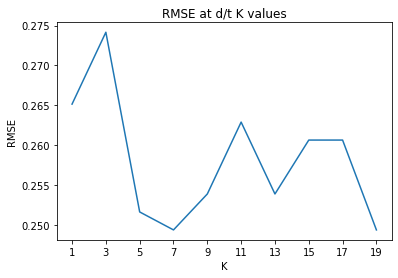

In [10]:
x = []
y = []

for i in knn_errors:
    x.append(i["K"])
    y.append(i["RMSE"])

x = np.array(x)
y = np.array(y)
fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_xlabel("K")
ax.set_ylabel("RMSE")
ax.set_title("RMSE at d/t K values")
plt.xticks(np.arange(min(x), max(x) + 1, 2))
fig.show()

In [12]:
knn_imputer = KNNImputer(n_neighbors=7)
df = ge_state_outcome_df.drop(["patient_ID"], axis=1)
df_new = knn_imputer.fit_transform(df)
ge_state_outcome_df_v2 = pd.DataFrame(df_new, columns=df.columns)
patient_id = state_df["patient_ID"]
ge_state_outcome_df_v2 = pd.concat([patient_id, ge_state_outcome_df_v2], axis=1)
ge_state_outcome_df_v2[ge_state_outcome_df_v2["patient_ID"] == 36777]

,patient_ID,gpl,ER,HER2,PR,node,tumor,pam_coincide,p5,posOutcome,...,ZNF80,ZNF83,ZNF84,ZNF91,ZNHIT2,ZSCAN2,ZXDC,ZYX,ZZEF1,ZZZ3
103,36777,5.0,1.0,0.0,1.0,0.0,1.0,2.0,3.0,1.0,...,3.470001,7.501974,6.863132,9.462132,3.471157,3.547679,5.136034,6.389269,5.735924,6.057025


In [15]:
X, y = ge_state_outcome_df_v2.drop(["patient_ID", "posOutcome"], axis=1), ge_state_outcome_df_v2["posOutcome"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                    test_size=0.3, random_state=seed)

In [17]:
params_all, clf_all, cv_scores_all, test_scores_all = evaluate_ge(X_train, y_train, X_test, y_test, state_df.columns.tolist())

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[14:05:10] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:05:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Time taken: 1 hours 16 minutes and 32.28 seconds.
Best Score: 85.124%
{'subsample': 0.8, 'n_estimators': 400, 'min_child_weight': 2, 'max_depth': 5, 'learning_rate': 0.03, 'gamma': 0.5, 'colsample_bytree': 0.6}
[14:13:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 71.7min finished


In [18]:
cv_scores_all.mean()

balanced_accuracy    0.779417
recall_0             0.794416
precision_0          0.785126
recall_1             0.765337
precision_1          0.773708
auc                  0.851240
dtype: float64

In [22]:
test_scores_all.mean()

balanced_accuracy    0.787903
recall_0             0.795518
precision_0          0.806818
recall_1             0.781350
precision_1          0.768987
auc                  0.867475
dtype: float64